# Предобработка данных

## Настройка контраста и яркости

In [35]:
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm
from scipy import stats
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, make_scorer

from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.decomposition import PCA, TruncatedSVD
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")
LOCAL_PATH = '.'
SEED = 42
np.random.seed(SEED)

In [148]:
# для запуска в Google colab7
def in_colab():
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

print(in_colab())
if in_colab():
    import kagglehub

    # Download latest version
    path = kagglehub.dataset_download("cjinny/mura-v11")

    print("Path to dataset files:", path)
else:
    path=LOCAL_PATH

False


In [149]:
# для запуска в Google colab
image_dir = Path(path) / "MURA-v1.1"

In [150]:
# датасет
#image_dir = Path('MURA-v1.1')

# Из результатов EDA нам известно, что 4 изображения из датасета "unreadable". Сразу отфильтруем их.
valid_paths = []
for path in tqdm(image_dir.rglob('*.*'), desc='Фильтрация читаемых изображений', unit='img'):
    if path.suffix.lower() in {".png", ".jpg", ".jpeg"}:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            valid_paths.append(path)

print(len(valid_paths))


Фильтрация читаемых изображений: 0img [00:00, ?img/s]

Фильтрация читаемых изображений: 40013img [01:06, 603.34img/s]

40005


#### Применим методы createCLAHE и convertScaleAbs из библиотеки cv2 ко всем изображениям, учитывая текущие их показатели яркости и контраста.
Оптимальные параметры для каждой группы изображений подобраны путем подбора и анализа результатов обработки.

In [ ]:
# определение параметров в зависимости от текущей яркости изображений
def parameters(mean, std):
    # Контраст
    if std < 30:
        alpha = 1.3
    elif std < 50:
        alpha = 1.1
    else:
        alpha = 1.0

    # Яркость
    if mean < 40:
        beta = 20
    elif mean < 70:
        beta = 10
    else:
        beta = 0

    clip_limit = 3

    return alpha, beta, clip_limit

# функция сохранения изображений
def save_processed(img, original_path, base_input_dir, base_output_dir):
    rel_path = os.path.relpath(original_path, base_input_dir)
    output_path = os.path.join(base_output_dir, rel_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, img)

# обработка и сохранение всех изображений
def process_images(df_subset, base_input_dir, base_output_dir, tile_grid_size=(10, 10)):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc='Обработка изображений'):
        path = row['path']
        mean = row['mean']
        std = row['std']

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        alpha, beta, clip_limit = parameters(mean, std)

        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)
        img_final = cv2.convertScaleAbs(img_clahe, alpha=alpha, beta=beta)

        save_processed(img_final, path, base_input_dir, base_output_dir)


In [152]:
#сбор датафрейма из EDA

def get_brightness_stats(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    # Переводим RGB в grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    stats = {
        'min': int(img.min()),
        'max': int(img.max()),
        'mean': float(img.mean()),
        'std': float(img.std()),
        'range': int(img.max() - img.min())
    }
    return stats

brightness_data = []

for path in tqdm(valid_paths, desc='Извлечение статистики яркости'):
    stats = get_brightness_stats(path)
    if stats:
        brightness_data.append({**stats, 'path': path})

brightness_df = pd.DataFrame(brightness_data)



Извлечение статистики яркости: 100%|██████████| 40005/40005 [01:20<00:00, 495.24it/s]


Посмотрим результат на нескольких примерах

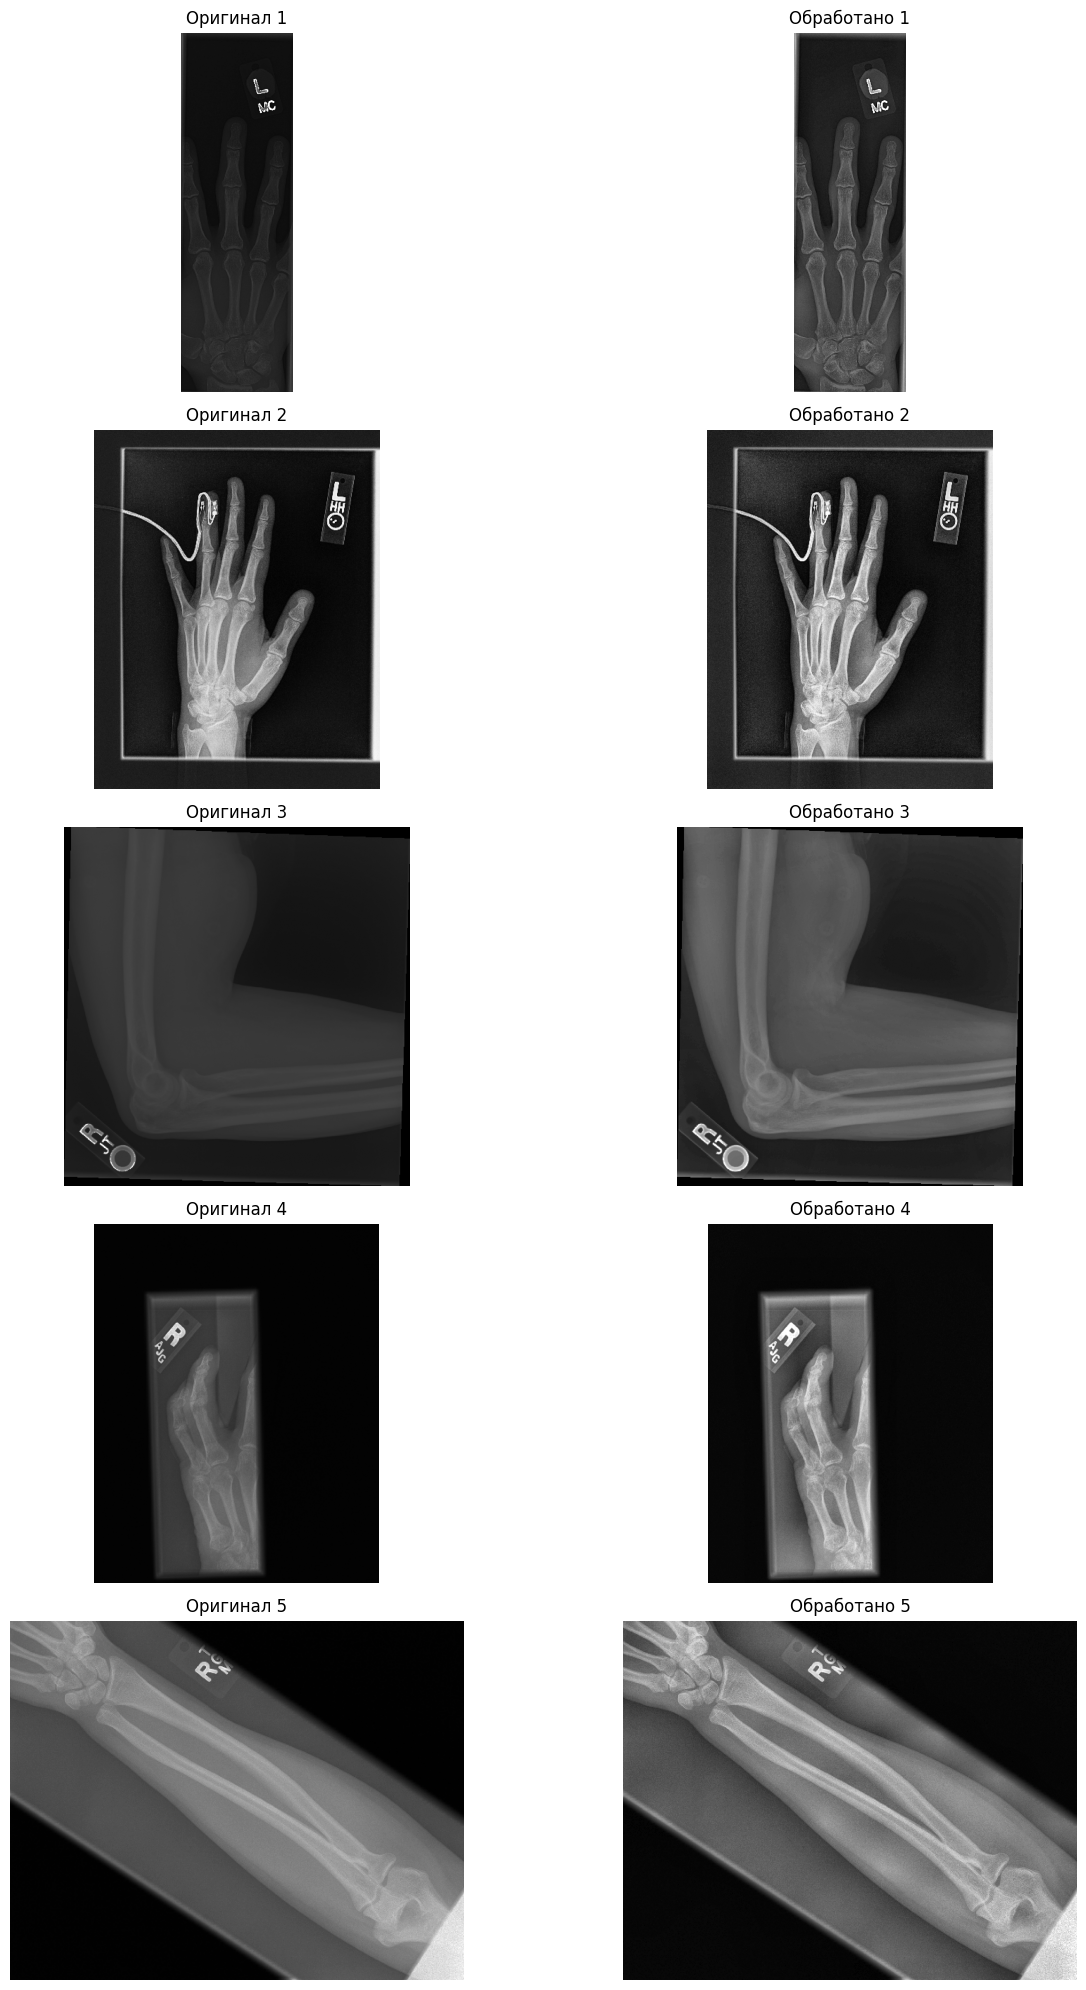

In [153]:
low_contrast_df = brightness_df.sort_values(by='std').head(5)

#выводим примеры изображений до/после
def enhance_comparison(paths, n=5):
    plt.figure(figsize=(14, 4 * n))
    paths = [*paths]
    np.random.seed(SEED)
    np.random.shuffle(paths)
    for i, path in enumerate(paths[:n]):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        brightness = np.mean(img)
        contrast = np.std(img)

        alpha, beta, clip_limit = parameters(brightness, contrast)
        tile_grid_size = (8, 8)

        # CLAHE + контраст/яркость
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        img_clahe = clahe.apply(img)
        enhanced = cv2.convertScaleAbs(img_clahe, alpha=alpha, beta=beta)

        # Оригинал
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Оригинал {i+1}')
        plt.axis('off')

        # Обработанное
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title(f'Обработано {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


enhance_comparison(valid_paths)

#### Невооруженным взглядом можно заметить, что контраст и читаемость изображений улучшились.


#### Применим функцию обработки к сформированному датасету

In [154]:
process_images(brightness_df,image_dir, 'MURA-enhanced')

Обработка изображений:   0%|          | 0/40005 [00:00<?, ?it/s]

Обработка изображений: 100%|██████████| 40005/40005 [02:40<00:00, 248.82it/s]


#### Проанализируем контрастность и яркость обработанного датасета.

In [155]:
#загружаем обработанный датасет
# датасет
enhanced_image_dir = 'MURA-enhanced'

#Пути к файлам
enhanced_paths = []
for root, dirs, files in os.walk(enhanced_image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            enhanced_paths.append(os.path.join(root, file))

In [156]:
enhanced_brightness_data = []

for path in tqdm(enhanced_paths, desc='Извлечение статистики яркости после обработки'):
    stats = get_brightness_stats(path)
    if stats:
        enhanced_brightness_data.append({**stats, 'path': path})

enhanced_brightness = pd.DataFrame(enhanced_brightness_data)
print(enhanced_brightness.describe())

Извлечение статистики яркости после обработки: 100%|██████████| 40005/40005 [01:14<00:00, 534.60it/s]

                min           max          mean           std         range
count  40005.000000  40005.000000  40005.000000  40005.000000  40005.000000
mean      18.229921    251.257468     84.626119     42.104639    233.027547
std       11.236937     12.525503     24.413656     11.397228     16.394736
min        0.000000     34.000000     23.003377      0.420841     13.000000
25%       12.000000    255.000000     71.403527     33.951035    232.000000
50%       13.000000    255.000000     80.298916     40.890575    234.000000
75%       23.000000    255.000000     92.198038     49.091548    243.000000
max      135.000000    255.000000    233.250778    105.742145    255.000000


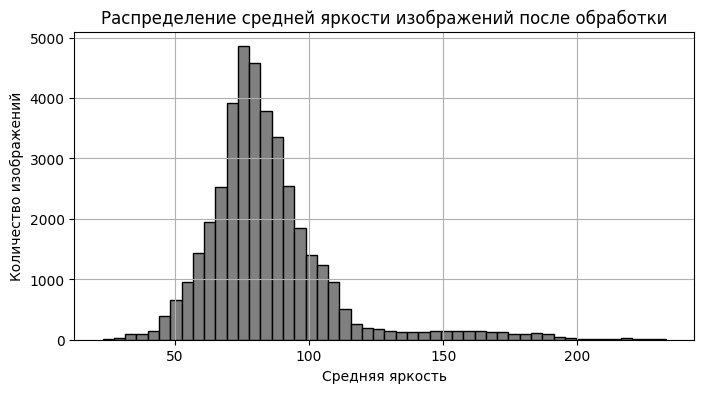

In [157]:
# Гистограмма средней яркости
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['mean'], bins=50, color='gray', edgecolor='black')
plt.title('Распределение средней яркости изображений после обработки')
plt.xlabel('Средняя яркость')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Среднее значение яркости увеличилось, что улучшило визуальное восприятие деталей.

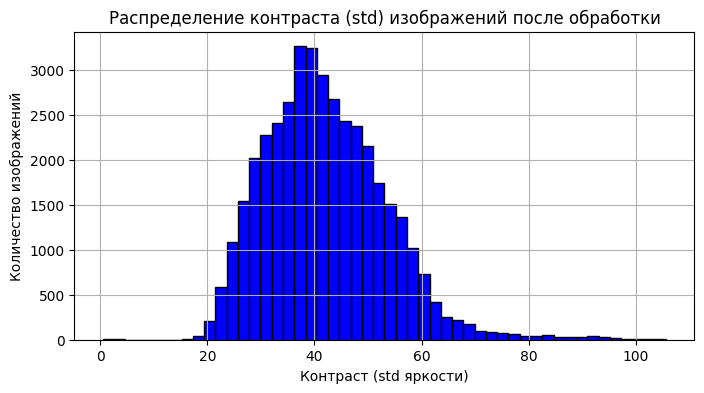

In [158]:
# Гистограмма стандартного отклонения (контраста)
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['std'], bins=50, color='blue', edgecolor='black')
plt.title('Распределение контраста (std) изображений после обработки')
plt.xlabel('Контраст (std яркости)')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

 Std вырос, особенно у изображений c совсем низким контрастом. Такое улучшение сделает границы и структуры более различимыми.

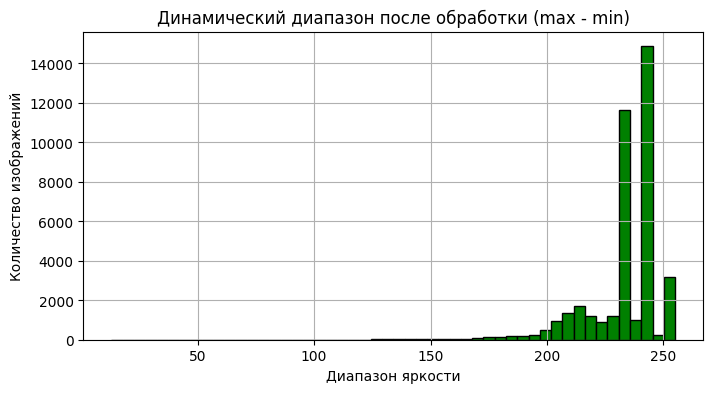

In [159]:
# Гистограмма динамического диапазона (max - min)
plt.figure(figsize=(8,4))
plt.hist(enhanced_brightness['range'], bins=50, color='green', edgecolor='black')
plt.title('Динамический диапазон после обработки (max - min)')
plt.xlabel('Диапазон яркости')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

На графике преобладают значения в диапазоне 230–255. Это говорит о том, что изображения охватывают почти весь возможный спектр яркости, что Отсутствие большого числа с узким диапазоном (ниже 200) — указывает на устранение «плоских» и недоэкспонированных изображений, в сравнении с первоначальными данными.

#### Посмотрим резкость изображений после обработки

In [160]:
#функция определения резкости из EDA
def compute_blur_score(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var

enhanced_blur_scores = []

for i, row in tqdm(enhanced_brightness.iterrows(), total=len(enhanced_brightness), desc='Извлечение статистики размытия после обработки'):
    score = compute_blur_score(row['path'])
    if score is not None:
        enhanced_blur_scores.append({'path': row['path'], 'blur_var': score})
enhanced_blur_df = pd.DataFrame(enhanced_blur_scores)


Извлечение статистики размытия после обработки: 100%|██████████| 40005/40005 [01:24<00:00, 471.22it/s]


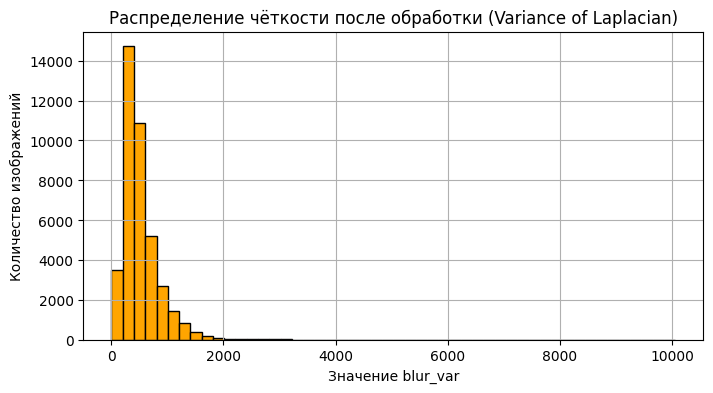

In [161]:
# Визуализация
plt.figure(figsize=(8,4))
plt.hist(enhanced_blur_df['blur_var'], bins=50, color='orange', edgecolor='black')
plt.title("Распределение чёткости после обработки (Variance of Laplacian)")
plt.xlabel("Значение blur_var")
plt.ylabel("Количество изображений")
plt.grid(True)
plt.show()

Распределение blur_var показывает, что большинство изображений имеют достаточную чёткость.

In [162]:
# доля потенциально размытых изображений
num_blurry = (enhanced_blur_df['blur_var'] < 50).sum()
total = len(enhanced_blur_df)
print(f"🔍 Сильно размытых изображений: {num_blurry} из {total} ({num_blurry/total:.2%})")

🔍 Сильно размытых изображений: 13 из 40005 (0.03%)


## Преобразования размеров

In [163]:
image_dir = Path("MURA-enhanced")   # корень с исходными картинками
extensions = {".png", ".jpg", ".jpeg"}  # на всякий случай

def collect_image_dimensions(root_dir: Path):
    records = []
    for path in root_dir.rglob("*"):
        if path.suffix.lower() in extensions and not path.name.startswith("._"):
            try:
                with Image.open(path) as img:
                    w, h = img.size
            except Exception as e:
                print(f"⚠️ Ошибка при чтении {path}: {e}")
                continue
            records.append(
                {
                    "path": path,
                    "width": w,
                    "height": h,
                    "aspect_ratio": w / h if h != 0 else np.nan,
                }
            )
    df = pd.DataFrame(records)
    print(f"Всего найдено изображений: {len(df)}")
    return df

df_dimensions = collect_image_dimensions(image_dir)
display(df_dimensions.head())


Всего найдено изображений: 40005


,path,width,height,aspect_ratio
0,MURA-enhanced/train/XR_HAND/patient10502/study...,336,512,0.656250
1,MURA-enhanced/train/XR_HAND/patient10502/study...,336,512,0.656250
2,MURA-enhanced/train/XR_HAND/patient10502/study...,322,512,0.628906
3,MURA-enhanced/train/XR_HAND/patient09246/study...,278,512,0.542969
4,MURA-enhanced/train/XR_HAND/patient09246/study...,316,512,0.617188


In [164]:
X = df_dimensions[["aspect_ratio"]].values

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init="auto"  # если sklearn>=1.4, иначе можно убрать этот параметр
)

df_dimensions["ar_cluster"] = kmeans.fit_predict(X)

cluster_stats = (
    df_dimensions
    .groupby("ar_cluster")
    .agg(
        count=("aspect_ratio", "size"),
        mean_ar=("aspect_ratio", "mean"),
        median_ar=("aspect_ratio", "median"),
        std_ar=("aspect_ratio", "std"),
        mean_w=("width", "mean"),
        median_w=("width", "median"),
        std_w=("width", "std"),
        mean_h=("height", "mean"),
        median_h=("height", "median"),
        std_h=("height", "std"),
    )
)
display(cluster_stats)

,count,mean_ar,median_ar,std_ar,mean_w,median_w,std_w,mean_h,median_h,std_h
ar_cluster,,,,,,,,,,
0,7785,1.293487,1.261084,0.247560,512.000000,512.0,0.000000,404.153243,406.0,46.086209
1,23995,0.806505,0.792969,0.077577,412.657512,406.0,38.975324,511.735195,512.0,2.002285
2,8225,0.496859,0.511719,0.102084,254.391733,262.0,52.266841,512.000000,512.0,0.000000


In [165]:
# Размеры, рекомендованные chatgpt как более оптимальные
# TARGET_H = 256
# TARGET_W = 320
TARGET_H = 224
TARGET_W = 224

def resize_with_padding(img: Image.Image,
                        target_h: int = TARGET_H,
                        target_w: int = TARGET_W) -> Image.Image:
    """
    Ресайз изображения с сохранением пропорций + центрированный паддинг
    до (target_h, target_w).
    """
    w, h = img.size

    # Первый шаг: пробуем масштабировать по высоте
    if h > 0:
        scale = target_h / h
    else:
        scale = 1.0

    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    # Если по высоте всё хорошо, но ширина вдруг слишком большая — масштабируем по ширине
    if new_w > target_w:
        scale = target_w / w
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))

    # Собственно ресайз
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)

    # Паддинг до нужного размера
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top

    # Фон чёрный (0), под рентгены как раз
    img_padded = ImageOps.expand(
        img_resized,
        border=(pad_left, pad_top, pad_right, pad_bottom),
        fill=0
    )

    return img_padded


In [166]:
output_root = Path(f"MURA-v1.1-resized-{TARGET_W}x{TARGET_H}")
output_root.mkdir(parents=True, exist_ok=True)

def save_resized_dataset(df: pd.DataFrame,
                         input_root: Path,
                         output_root: Path):
    num_saved = 0
    for i, row in df.iterrows():
        src_path: Path = row["path"]
        rel_path = src_path.relative_to(input_root)  # относительный путь от корня
        dst_path = output_root / rel_path

        dst_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with Image.open(src_path) as img:
                img = img.convert("L")  # на всякий случай делаем grayscale
                img_resized = resize_with_padding(img)
                img_resized.save(dst_path)
            num_saved += 1
        except Exception as e:
            print(f"⚠️ Ошибка при обработке {src_path}: {e}")

    print(f"Готово! Сохранено изображений: {num_saved}")

save_resized_dataset(df_dimensions, image_dir, output_root)


Готово! Сохранено изображений: 40005



=== Кластер 0 ===


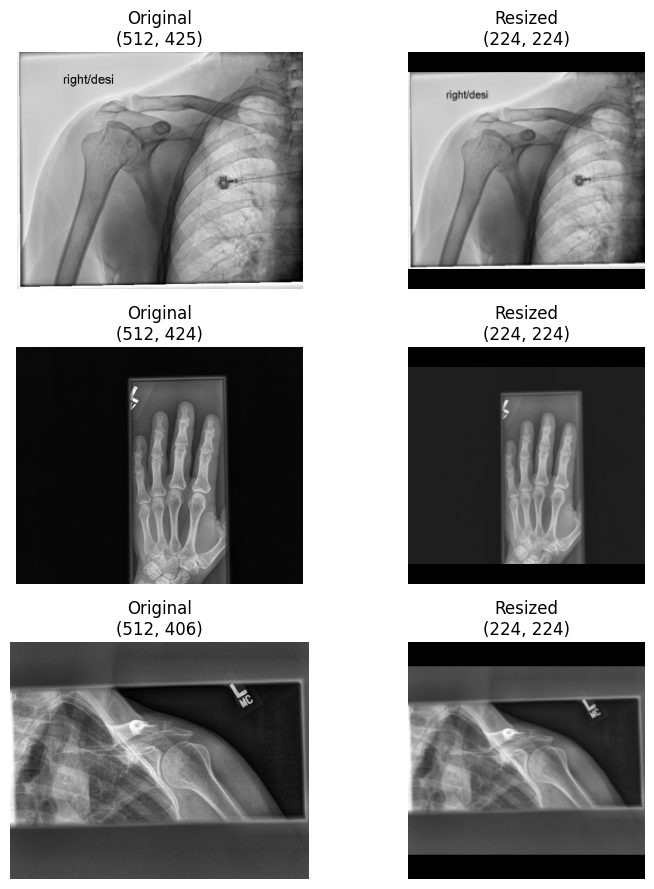


=== Кластер 1 ===


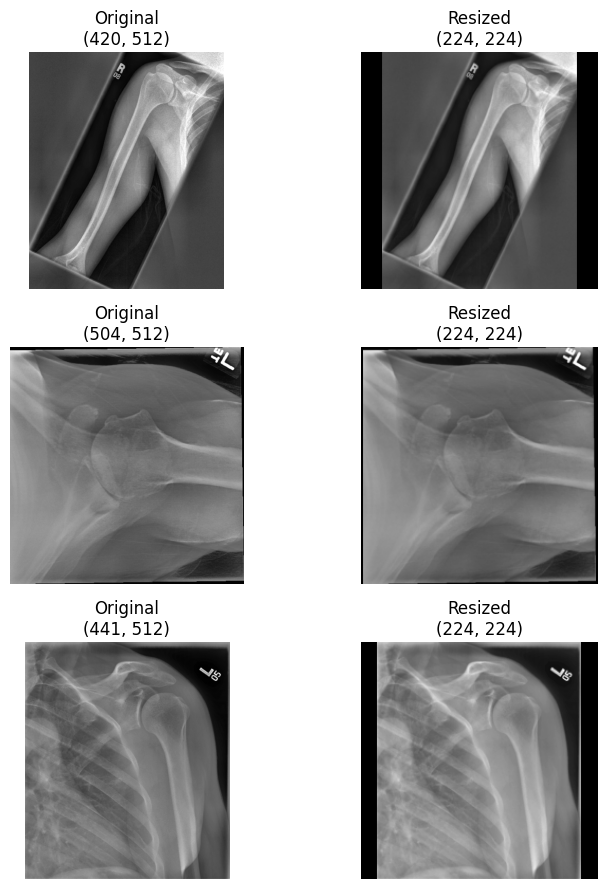


=== Кластер 2 ===


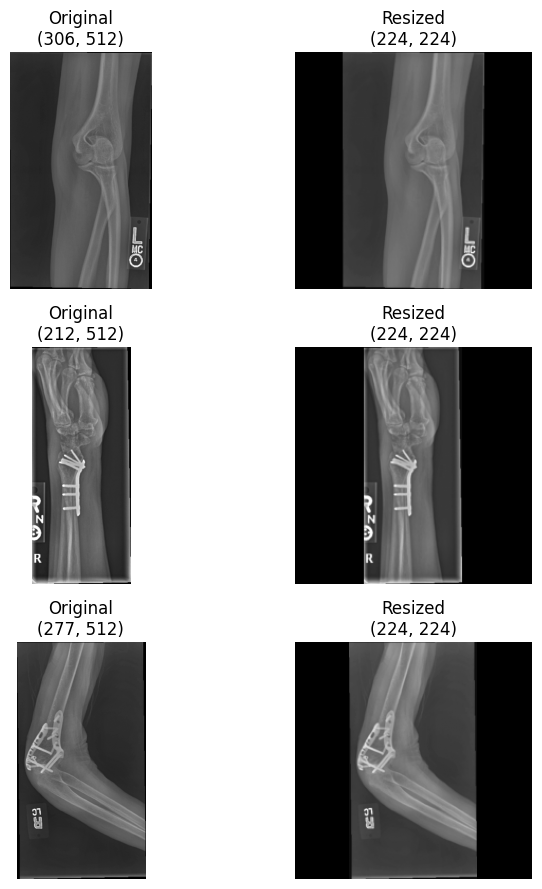

In [167]:
def show_cluster_examples(df: pd.DataFrame,
                          input_root: Path,
                          output_root: Path,
                          samples_per_cluster: int = 3):
    clusters = sorted(df["ar_cluster"].dropna().unique())
    for cl in clusters:
        print(f"\n=== Кластер {cl} ===")
        df_cl = df[df["ar_cluster"] == cl].sample(
            n=min(samples_per_cluster, (df["ar_cluster"] == cl).sum()),
            random_state=42
        )

        fig, axes = plt.subplots(
            nrows=samples_per_cluster,
            ncols=2,
            figsize=(8, 3 * samples_per_cluster)
        )

        if samples_per_cluster == 1:
            axes = np.array([axes])  # чтобы всегда была 2D-матрица

        for row_idx, (_, row) in enumerate(df_cl.iterrows()):
            src_path: Path = row["path"]
            rel_path = src_path.relative_to(input_root)
            dst_path = output_root / rel_path

            # Оригинал
            try:
                with Image.open(src_path) as img_orig:
                    axes[row_idx, 0].imshow(img_orig, cmap="gray")
                    axes[row_idx, 0].set_title(f"Original\n{img_orig.size}")
                    axes[row_idx, 0].axis("off")
            except Exception as e:
                axes[row_idx, 0].set_title(f"Ошибка чтения\n{src_path}")
                axes[row_idx, 0].axis("off")

            # Ресайз
            try:
                with Image.open(dst_path) as img_resized:
                    axes[row_idx, 1].imshow(img_resized, cmap="gray")
                    axes[row_idx, 1].set_title(f"Resized\n{img_resized.size}")
                    axes[row_idx, 1].axis("off")
            except Exception as e:
                axes[row_idx, 1].set_title(f"Нет файла\n{dst_path}")
                axes[row_idx, 1].axis("off")

        plt.tight_layout()
        plt.show()

show_cluster_examples(df_dimensions, image_dir, output_root, samples_per_cluster=3)

# Обучение моделей

## Загрузка данных

#### Импорты и пути

In [21]:
%load_ext autoreload
%autoreload 2
import importlib
import ml
importlib.reload(ml)
import os
from ml.env import DATA_ROOT

assert os.path.exists(DATA_ROOT), f"Папка {DATA_ROOT} не найдена. Укажите правильный путь."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Загрузка датафрейма

In [22]:

from ml.data import build_dataframe
# Загрузка основного датафрейма
df = build_dataframe(DATA_ROOT)
print(f"Загружено {len(df)} исследований от {df['patient_id'].nunique()} пациентов.")

Загружаем датафрейм с данными из корня: MURA-v1.1-resized-224x224


Обработка анатомий в valid: 100%|██████████| 7/7 [00:00<00:00, 409.67it/s]

Загружено 14656 исследований от 11967 пациентов.


In [23]:
# Сохраним результаты в массив для тепловой карты
total_resutls_anatomies = []
total_resutls_all = []
def save_result(results, is_anatomy=True):
    total_resutls_anatomies.append(results)

## LogisticRegression, RidgeClassifier, LinearSVC по статистическим данным картинок

### Без подбора параметров

In [24]:
%load_ext autoreload
%autoreload 2
import importlib
import ml
importlib.reload(ml)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from ml.linear import prepare_data_for_anatomy
from ml.fit import fit_pipeline_anatomies
from sklearn.pipeline import Pipeline
import pandas as pd
fixed_models = {
    'LogisticRegression_Fixed': {
        'model_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
        ]),
        'use_decision_function':False
    },
    'RidgeClassifier_Fixed': {
        'model_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RidgeClassifier(random_state=42, class_weight='balanced'))
        ])
    },
    'LinearSVC_Fixed': {
        'model_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LinearSVC(random_state=42, class_weight='balanced', max_iter=10000))
        ]),
        'use_decision_function':True
    },
}

results_linear_fixed = []
for model_name, model_params in fixed_models.items():
    for use_all in [True, False]:
        current_result = fit_pipeline_anatomies(
            paths_df=df,
            get_data_for_anatomy=prepare_data_for_anatomy,
            model_name_base=model_name,
            use_all=use_all,
            **model_params
        )
        results_linear_fixed.append(current_result)
        save_result(current_result, is_anatomy=not use_all)

results_linear_fixed_df = pd.concat(results_linear_fixed, ignore_index=True)

results_linear_fixed_avg_df = results_linear_fixed_df.groupby('model_name_base')[['valid_kappa', 'valid_roc_auc']].mean().sort_values(by=['valid_kappa', 'valid_roc_auc'], ascending=False)
display(results_linear_fixed_avg_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_LogisticRegression_Fixed_all.csv
Загружены результаты модели LogisticRegression_Fixed из файла.
Загрузка результатов из results/results_LogisticRegression_Fixed.csv
Загружены результаты модели LogisticRegression_Fixed из файла.
Загрузка результатов из results/results_RidgeClassifier_Fixed_all.csv
Загружены результаты модели RidgeClassifier_Fixed из файла.
Загрузка результатов из results/results_RidgeClassifier_Fixed.csv
Загружены результаты модели RidgeClassifier_Fixed из файла.
Загрузка результатов из results/results_LinearSVC_Fixed_all.csv
Загружены результаты модели LinearSVC_Fixed из файла.
Загрузка результатов из results/results_LinearSVC_Fixed.csv
Загружены результаты модели LinearSVC_Fixed из файла.


,valid_kappa,valid_roc_auc
model_name_base,,
RidgeClassifier_Fixed,0.197699,0.632150
LinearSVC_Fixed,0.196290,0.631923
LogisticRegression_Fixed,0.193396,0.631429


### С подбором параметров через Grid Search

In [25]:
%load_ext autoreload
%autoreload 2
import importlib
import ml
importlib.reload(ml)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from ml.linear import prepare_data_for_anatomy
from ml.fit import fit_pipeline_anatomies
from sklearn.pipeline import Pipeline

models_and_params = {
    'LogisticRegression_GridSearch': {
        'model_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(random_state=42, class_weight='balanced', max_iter=10000))
        ]),
        'params': {
            'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear']
        }
    },
    'RidgeClassifier_GridSearch': {
        'model_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', RidgeClassifier(random_state=42, class_weight='balanced', max_iter=10000))
        ]),
        'params': {
            'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'LinearSVC_GridSearch': {
        'model_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LinearSVC(random_state=42, class_weight='balanced', max_iter=10000))
        ]),
        'params': {
            'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'clf__penalty': ['l2'],
            'clf__dual': ['auto'],
            'clf__max_iter': [10000]
        }
    }
}
results_linear_gridsearch = []
results_linear_gridsearch = []
for model_name, model_data in models_and_params.items():
    model_pipeline = model_data['model_pipeline']
    model_gridsearch_params = model_data['params']
    for use_all in [False, True]:
        current_result = fit_pipeline_anatomies(
            model_pipeline=model_pipeline,
            paths_df=df,
            get_data_for_anatomy=prepare_data_for_anatomy,
            model_name_base=model_name,
            param_grid=model_gridsearch_params,
            use_decision_function=False if model_name == 'LogisticRegression_GridSearch' else True,
            use_all=use_all
        )
        results_linear_gridsearch.append(current_result)
        save_result(current_result, is_anatomy=not use_all)

results_linear_gridsearch_df = pd.concat(results_linear_gridsearch, ignore_index=True)
results_linear_gridsearch_avg_df = results_linear_gridsearch_df.groupby('model_name_base')[['valid_kappa', 'valid_roc_auc']].mean().sort_values(by=['valid_kappa', 'valid_roc_auc'], ascending=False)
display(results_linear_gridsearch_avg_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_LogisticRegression_GridSearch.csv
Загружены результаты модели LogisticRegression_GridSearch из файла.
Загрузка результатов из results/results_LogisticRegression_GridSearch_all.csv
Загружены результаты модели LogisticRegression_GridSearch из файла.
Загрузка результатов из results/results_RidgeClassifier_GridSearch.csv
Загружены результаты модели RidgeClassifier_GridSearch из файла.
Загрузка результатов из results/results_RidgeClassifier_GridSearch_all.csv
Загружены результаты модели RidgeClassifier_GridSearch из файла.
Загрузка результатов из results/results_LinearSVC_GridSearch.csv
Загружены результаты модели LinearSVC_GridSearch из файла.
Загрузка результатов из results/results_LinearSVC_GridSearch_all.csv
Загружены результаты модели LinearSVC_GridSearch из файла.


,valid_kappa,valid_roc_auc
model_name_base,,
RidgeClassifier_GridSearch,0.207312,0.635639
LogisticRegression_GridSearch,0.200969,0.634145
LinearSVC_GridSearch,0.196112,0.635146


### Сравним результаты с подбором параметров

In [26]:
comparison_optimized_df = results_linear_gridsearch_df

# Преобразуем DataFrame
pivoted_kappa = comparison_optimized_df.pivot(index='anatomy', columns='model_name_base', values='valid_kappa')
display(pivoted_kappa)
pivoted_params = comparison_optimized_df.pivot(index='anatomy', columns='model_name_base', values='best_params')

# Найем лучшую модель для каждого анатомического участка
best_model_per_anatomy = pivoted_kappa.idxmax(axis=1)
best_kappa_per_anatomy = pivoted_kappa.max(axis=1)

# Найдем параметры лучшей модели для каждого участка
best_params_for_summary = []
for anatomy in best_model_per_anatomy.index:
    best_model_name = best_model_per_anatomy.loc[anatomy]
    best_params_str = pivoted_params.loc[anatomy, best_model_name]
    best_params_for_summary.append(best_params_str)

print("ЛУЧШИЕ МОДЕЛИ ПО АНАТОМИЧЕСКИМ УЧАСТКАМ (ПОСЛЕ GRIDSEARCHCV ПО KAPPA)")
print("Признаки: статистика интенсивности (1 изображение на исследование)")
best_results_summary = pd.DataFrame({
    'Best_Model': best_model_per_anatomy,
    'Best_Cohen_Kappa': best_kappa_per_anatomy,
    'Best_Params': best_params_for_summary
})
best_results_summary = best_results_summary.sort_values('Best_Cohen_Kappa', ascending=False)
print(best_results_summary.to_string())

model_name_base,LinearSVC_GridSearch,LogisticRegression_GridSearch,RidgeClassifier_GridSearch
anatomy,,,
NaN,0.137202,0.138426,0.133870
XR_ELBOW,0.054572,0.054572,0.079783
XR_FINGER,0.438184,0.415253,0.438184
XR_FOREARM,0.247056,0.262533,0.247056
XR_HAND,-0.096702,-0.046174,-0.022665
XR_HUMERUS,0.259544,0.274432,0.259544
XR_SHOULDER,0.319298,0.298969,0.298373
XR_WRIST,0.209745,0.209745,0.224348


ЛУЧШИЕ МОДЕЛИ ПО АНАТОМИЧЕСКИМ УЧАСТКАМ (ПОСЛЕ GRIDSEARCHCV ПО KAPPA)
Признаки: статистика интенсивности (1 изображение на исследование)
                                Best_Model  Best_Cohen_Kappa                                                                           Best_Params
anatomy                                                                                                                                           
XR_FINGER             LinearSVC_GridSearch          0.438184      {'clf__C': 1, 'clf__dual': 'auto', 'clf__max_iter': 10000, 'clf__penalty': 'l2'}
XR_SHOULDER           LinearSVC_GridSearch          0.319298  {'clf__C': 0.001, 'clf__dual': 'auto', 'clf__max_iter': 10000, 'clf__penalty': 'l2'}
XR_HUMERUS   LogisticRegression_GridSearch          0.274432                      {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
XR_FOREARM   LogisticRegression_GridSearch          0.262533                     {'clf__C': 100, 'clf__penalty': 'l1', 'clf__sol

### Тепловая карта

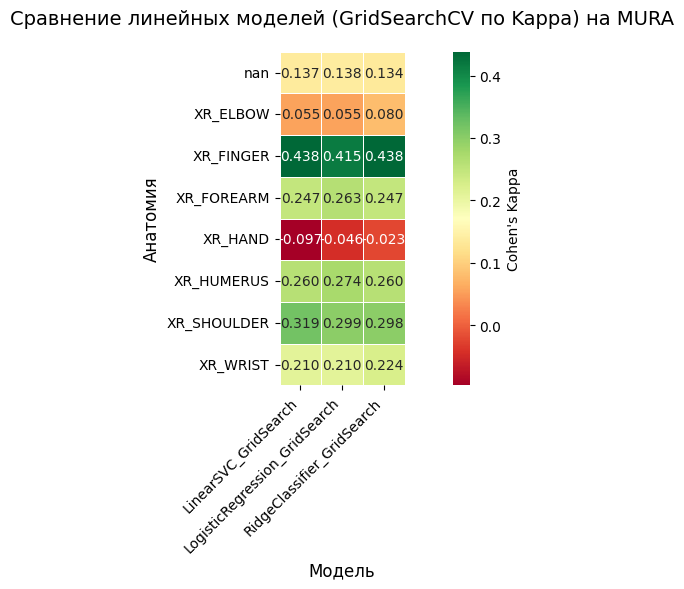

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt



model_columns = [col for col in pivoted_kappa.columns if col.endswith('_GridSearch')]
heatmap_data = pivoted_kappa[model_columns]

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    cbar_kws={'label': 'Cohen\'s Kappa'},
    linewidths=0.5,
    square=True
)

plt.title("Сравнение линейных моделей (GridSearchCV по Kappa) на MURA", fontsize=14, pad=20)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Анатомия", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_heatmap_by_results(comparison_dfs, values_for_pivot='valid_kappa', description="", heatmap_params={}, figsize=(10, 6)):
    comparison_df = pd.concat(comparison_dfs, ignore_index=True)
    comparison_df['anatomy'] = comparison_df['anatomy'].fillna('All Anatomies')
    pivoted_kappa = comparison_df.pivot(index='anatomy', columns='model_name_base', values=values_for_pivot)

    model_columns = [col for col in pivoted_kappa.columns if col != 'model_name_base']
    heatmap_data = pivoted_kappa[model_columns]
    default_heatmap_params = {
        'annot':True,
        'fmt':".3f",
        'cmap':"RdYlGn",
        'linewidths':0.5,
        'square':True,
    }

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        heatmap_data,
        **{**default_heatmap_params, **heatmap_params}
    )

    plt.title(f"Сравнение моделей (GridSearchCV по Kappa) на MURA по анатомиям {description} (Второй чекпойнт)", fontsize=14, pad=20)
    plt.xlabel("Модель", fontsize=12)
    plt.ylabel("Анатомия", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

## Добавляем HOG

### Загрузим датафрейм с путями картинок (не study)

In [29]:
%load_ext autoreload
%autoreload 2
import importlib
import ml
from ml.env import DATA_ROOT
from ml.data import build_dataframe
df_images = build_dataframe(DATA_ROOT, return_images=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загружаем датафрейм с данными из корня: MURA-v1.1-resized-224x224


Обработка анатомий в valid: 100%|██████████| 7/7 [00:00<00:00, 279.50it/s]


### XGBoost + дополнительные признаки(CLAHE + HOG + LBP + PCA)

#### По анатомиям

In [30]:
%load_ext autoreload
%autoreload 2
import importlib
import ml
import ml.xgboost
importlib.reload(ml)
importlib.reload(ml.xgboost)
from sklearn.linear_model import LogisticRegression
from ml.fit import fit_pipeline_anatomies
from ml.xgboost import prepare_xgboost_data_for_anatomy
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

model_xgb = Pipeline([
    ('clf', XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False
    ))
])
results_xgboost_df = fit_pipeline_anatomies(
    model_pipeline=model_xgb,
    paths_df=df_images,
    get_data_for_anatomy=prepare_xgboost_data_for_anatomy,
    model_name_base='XGBClassifier_Fixed',
    use_decision_function=False,
    # use_all=True
)
display(results_xgboost_df)
save_result(results_xgboost_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_XGBClassifier_Fixed.csv
Загружены результаты модели XGBClassifier_Fixed из файла.


,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,XR_HUMERUS,1.000000,0.332303,1.000000,0.666667,1.000000,0.652174,{},1.000000,0.747346,XGBClassifier_Fixed,1.813710,0.008997
1,XR_WRIST,0.941396,0.441966,0.971698,0.729894,0.965283,0.660305,{},0.996421,0.797374,XGBClassifier_Fixed,3.510682,0.063309
2,XR_ELBOW,0.993693,0.339813,0.996958,0.670968,0.996253,0.610687,{},0.999980,0.738242,XGBClassifier_Fixed,2.904488,0.036715
3,XR_FINGER,0.989243,0.395885,0.994908,0.694143,0.993381,0.677346,{},0.999807,0.765201,XGBClassifier_Fixed,2.712676,0.029398
4,XR_SHOULDER,0.957752,0.371101,0.978876,0.685613,0.978866,0.681081,{},0.997822,0.736968,XGBClassifier_Fixed,3.400840,0.023393
5,XR_FOREARM,1.000000,0.256888,1.000000,0.627907,1.000000,0.525424,{},1.000000,0.700883,XGBClassifier_Fixed,1.977695,0.026086
6,XR_HAND,0.992150,0.122235,0.996933,0.626087,0.994239,0.245614,{},0.999997,0.665241,XGBClassifier_Fixed,2.836196,0.025585


#### По всему датасету

In [31]:
%load_ext autoreload
%autoreload 2
import importlib
import ml
import ml.xgboost
importlib.reload(ml)
importlib.reload(ml.xgboost)
from sklearn.linear_model import LogisticRegression
from ml.fit import fit_pipeline_anatomies
from ml.xgboost import prepare_xgboost_data_for_anatomy
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

model_xgb_all = Pipeline([
    ('clf', XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False
    ))
])
results_xgboost_all_df = fit_pipeline_anatomies(
    model_pipeline=model_xgb_all,
    paths_df=df_images,
    get_data_for_anatomy=prepare_xgboost_data_for_anatomy,
    model_name_base='XGBClassifier_Fixed',
    use_decision_function=False,
    use_all=True
)
display(results_xgboost_all_df)
save_result(results_xgboost_all_df, is_anatomy=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_XGBClassifier_Fixed_all.csv
Загружены результаты модели XGBClassifier_Fixed из файла.


,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,NaN,0.650451,0.298511,0.836041,0.654676,0.779269,0.567398,{},0.921213,0.713357,XGBClassifier_Fixed,5.543679,0.032486


### HOG + SVC

> Все модели в этом разделе используют усредненное по исследованию значение

In [32]:
%load_ext autoreload
%autoreload 2
import importlib
from IPython.display import Markdown
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

import ml
importlib.reload(ml)
from ml.fit import fit_pipeline_anatomies
from ml.hog import prepare_data_for_anatomy

from sklearn.metrics import make_scorer, cohen_kappa_score
kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

pipeline_hog_svc = Pipeline([
    ("clf", LinearSVC())
])
param_grid_svc = {
    "clf__C": [0.1, 0.03, 0.003]
}

for use_all in [True, False]:  # , True
    current_result = fit_pipeline_anatomies(
        model_pipeline=pipeline_hog_svc,
        param_grid=param_grid_svc,
        model_name_base="hog_svc",
        paths_df=df,
        grid_search_params={'n_jobs': 4, 'verbose': 3},
        get_data_for_anatomy=prepare_data_for_anatomy,
        use_all=use_all,
    )
    save_result(current_result, is_anatomy=not use_all)

    display(Markdown(f"#### Результаты HOG + SVC по всему датасету:{use_all}"))
    display(current_result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_hog_svc_all.csv
Загружены результаты модели hog_svc из файла.


#### Результаты HOG + SVC по всему датасету:True

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,NaN,0.601314,0.265593,0.816824,0.644704,0.741587,0.550633,{'clf__C': 0.003},0.891573,0.687254,hog_svc,17.189167,0.631239


Загрузка результатов из results/results_hog_svc.csv
Загружены результаты модели hog_svc из файла.


#### Результаты HOG + SVC по всему датасету:False

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,XR_HUMERUS,0.942105,0.259544,0.971284,0.629630,0.968460,0.637681,{'clf__C': 0.003},0.995655,0.689860,hog_svc,0.609575,0.020832
1,XR_WRIST,0.729092,0.528322,0.873121,0.780591,0.830305,0.694118,{'clf__C': 0.003},0.942961,0.814359,hog_svc,3.903783,0.126885
2,XR_ELBOW,1.000000,0.285949,1.000000,0.651899,1.000000,0.586466,{'clf__C': 0.03},1.000000,0.647398,hog_svc,7.322172,0.186286
3,XR_FINGER,0.759100,0.491010,0.891473,0.748571,0.841629,0.706667,{'clf__C': 0.003},0.956788,0.832373,hog_svc,1.688553,0.059217
4,XR_SHOULDER,0.804249,0.318429,0.902162,0.659794,0.904300,0.641304,{'clf__C': 0.003},0.962957,0.713344,hog_svc,3.487593,0.030391
5,XR_FOREARM,1.000000,0.256644,1.000000,0.631579,1.000000,0.573913,{'clf__C': 0.03},1.000000,0.662364,hog_svc,2.699276,0.094906
6,XR_HAND,1.000000,0.096714,1.000000,0.598802,1.000000,0.361905,{'clf__C': 0.1},1.000000,0.604710,hog_svc,12.974549,0.146709


### HOG + SVC + PCA

In [33]:
%load_ext autoreload
%autoreload 2
import importlib
from IPython.display import Markdown
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import ml
importlib.reload(ml)
from ml.fit import fit_pipeline_anatomies
from ml.hog import prepare_data_for_anatomy


for use_all in [False, True]:
    pipe_pca_kappa = Pipeline([
        ('pca', PCA(whiten=True)),
        ("clf", LinearSVC())
    ])
    N_JOBS = 5 if use_all else 8
    CLF_C = [0.01, 0.1, 1.0] if use_all else [0.001, 0.003, 0.008, 0.025, 0.5, 1.0]
    PCA_COMPONENTS =[50, 100] if use_all else [200, 300, 500] 
    current_result = fit_pipeline_anatomies(
        model_pipeline=pipe_pca_kappa,
        param_grid={
            "pca__n_components": PCA_COMPONENTS,
            "clf__C": CLF_C
        },
        model_name_base="hog_pca_svc__kappa",
        paths_df=df,
        grid_search_params={'n_jobs': N_JOBS, 'verbose': 3},
        get_data_for_anatomy=prepare_data_for_anatomy,
        use_all=use_all,
    )
    save_result(current_result, is_anatomy=not use_all)

    display(Markdown(f"#### Результаты HOG + PCA + SVC по всему датасету: {use_all}"))
    display(current_result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_hog_pca_svc__kappa.csv
Загружены результаты модели hog_pca_svc__kappa из файла.


#### Результаты HOG + PCA + SVC по всему датасету: False

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,XR_HUMERUS,0.665772,0.215374,0.834459,0.607407,0.816479,0.624113,"{'clf__C': 0.025, 'pca__n_components': 200}",0.915336,0.662423,hog_pca_svc__kappa,2.153828,0.243728
1,XR_WRIST,0.564923,0.538153,0.796821,0.784810,0.726139,0.701754,"{'clf__C': 1.0, 'pca__n_components': 300}",0.871271,0.822165,hog_pca_svc__kappa,8.891741,1.147479
2,XR_ELBOW,0.428315,0.217296,0.742303,0.626582,0.619529,0.520325,"{'clf__C': 0.008, 'pca__n_components': 200}",0.796610,0.646410,hog_pca_svc__kappa,4.231098,0.251599
3,XR_FINGER,0.575465,0.523161,0.807752,0.765714,0.722388,0.709220,"{'clf__C': 0.001, 'pca__n_components': 200}",0.871406,0.841409,hog_pca_svc__kappa,4.404573,0.470352
4,XR_SHOULDER,0.434104,0.227625,0.717122,0.613402,0.722724,0.619289,"{'clf__C': 0.025, 'pca__n_components': 200}",0.793853,0.688464,hog_pca_svc__kappa,8.512593,0.448298
5,XR_FOREARM,0.867336,0.179388,0.941847,0.593985,0.910369,0.517857,"{'clf__C': 0.003, 'pca__n_components': 500}",0.984539,0.660326,hog_pca_svc__kappa,6.518208,0.481089
6,XR_HAND,0.556308,0.115659,0.842914,0.622754,0.655809,0.307692,"{'clf__C': 1.0, 'pca__n_components': 500}",0.880971,0.658716,hog_pca_svc__kappa,9.689992,0.504023


Загрузка результатов из results/results_hog_pca_svc__kappa_all.csv
Загружены результаты модели hog_pca_svc__kappa из файла.


#### Результаты HOG + PCA + SVC по всему датасету: True

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,NaN,0.272445,0.20018,0.675262,0.620517,0.501938,0.457688,"{'clf__C': 0.1, 'pca__n_components': 100}",0.714064,0.670253,hog_pca_svc__kappa,21.459129,1.295768


### HOG + PCA + LogisticRegression

In [34]:
%load_ext autoreload
%autoreload 2
from sklearn.pipeline import Pipeline
import importlib
from sklearn.decomposition import PCA
from IPython.display import Markdown
import ml
importlib.reload(ml)
from sklearn.linear_model import LogisticRegression
from ml.fit import fit_pipeline_anatomies
from ml.hog import prepare_data_for_anatomy


pipe_pca_logreg = Pipeline([
    ('pca', PCA(whiten=True)),
    ("clf",  LogisticRegression(
        max_iter=1000,
        n_jobs=8,
        class_weight="balanced",
    ))
])
for use_all in [False, True]:
    N_JOBS = 5 if use_all else 8
    PCA_COMPONENTS =[50, 100] if use_all else [200, 300, 500] 
    CLF_C = [0.001, 0.01, 0.5] if use_all else [0.001, 0.01, 0.1, 0.5, 1.0]
    current_result = fit_pipeline_anatomies(
        model_pipeline=pipe_pca_logreg,
        param_grid={
            "pca__n_components": PCA_COMPONENTS,
            "clf__C": CLF_C
        },
        model_name_base="hog_pca_logreg",
        paths_df=df,
        grid_search_params={'n_jobs': N_JOBS, 'verbose': 3},
        get_data_for_anatomy=prepare_data_for_anatomy,
        use_all=use_all
    )
    save_result(current_result, is_anatomy=not use_all)

    display(Markdown(f"#### Результаты HOG + PCA + Logistic Regression по всему датасету: {use_all}"))
    display(current_result)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_hog_pca_logreg.csv
Загружены результаты модели hog_pca_logreg из файла.


#### Результаты HOG + PCA + Logistic Regression по всему датасету: False

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,XR_HUMERUS,0.789399,0.244983,0.895270,0.622222,0.886861,0.638298,"{'clf__C': 0.01, 'pca__n_components': 300}",0.967824,0.708516,hog_pca_logreg,5.368616,0.907935
1,XR_WRIST,0.553569,0.511340,0.781214,0.763713,0.739773,0.711340,"{'clf__C': 1.0, 'pca__n_components': 300}",0.870377,0.813181,hog_pca_logreg,14.631996,1.930588
2,XR_ELBOW,0.510532,0.191557,0.761688,0.594937,0.710526,0.561644,"{'clf__C': 0.1, 'pca__n_components': 300}",0.838005,0.636364,hog_pca_logreg,9.332399,1.075761
3,XR_FINGER,0.530858,0.530463,0.768992,0.765714,0.716550,0.754491,"{'clf__C': 0.001, 'pca__n_components': 200}",0.869981,0.843504,hog_pca_logreg,7.043527,0.411145
4,XR_SHOULDER,0.439632,0.226640,0.719603,0.613402,0.720988,0.607330,"{'clf__C': 0.001, 'pca__n_components': 200}",0.795722,0.693355,hog_pca_logreg,13.484841,1.317833
5,XR_FOREARM,0.495343,0.082966,0.761688,0.541353,0.680916,0.534351,"{'clf__C': 0.001, 'pca__n_components': 200}",0.846424,0.596920,hog_pca_logreg,4.441356,0.229870
6,XR_HAND,0.533466,0.217013,0.794351,0.622754,0.676539,0.533333,"{'clf__C': 0.01, 'pca__n_components': 500}",0.889273,0.658416,hog_pca_logreg,15.679727,1.670259


Загрузка результатов из results/results_hog_pca_logreg_all.csv
Загружены результаты модели hog_pca_logreg из файла.


#### Результаты HOG + PCA + Logistic Regression по всему датасету: True

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,NaN,0.298865,0.239715,0.64903,0.618849,0.604406,0.603643,"{'clf__C': 0.5, 'pca__n_components': 100}",0.716371,0.674685,hog_pca_logreg,20.053521,1.98204


### HOG + TruncatedSvd + Logistic regression

In [35]:
%load_ext autoreload
%autoreload 2
from sklearn.pipeline import Pipeline
import importlib
from IPython.display import Markdown
import ml
importlib.reload(ml)
from sklearn.linear_model import LogisticRegression
from ml.fit import fit_pipeline_anatomies
from ml.hog import prepare_data_for_anatomy
from sklearn.decomposition import TruncatedSVD



for use_all in [False, True]:
    pipe_svd_logreg = Pipeline([
        ("svd", TruncatedSVD()),
        ("clf",  LogisticRegression(
            max_iter=1000,
            n_jobs=8,
            class_weight="balanced",
        ))
    ])
    current_result = fit_pipeline_anatomies(
        model_pipeline=pipe_svd_logreg,
        param_grid={
            "svd__n_components": [50, 100],
            "clf__C": [0.01, 0.1]
        },
        model_name_base="hog_svd_logreg",
        paths_df=df,
        grid_search_params={'n_jobs': 5, 'verbose': 3},
        get_data_for_anatomy=prepare_data_for_anatomy,
        use_all=use_all
    )
    save_result(current_result, is_anatomy=not use_all)

    display(Markdown(f"#### Результаты HOG + SVD + Logistic Regression по всему датасету: {use_all}"))
    display(current_result)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_hog_svd_logreg.csv
Загружены результаты модели hog_svd_logreg из файла.


#### Результаты HOG + SVD + Logistic Regression по всему датасету: False

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,XR_HUMERUS,0.425184,0.215202,0.712838,0.607407,0.698582,0.618705,"{'clf__C': 0.1, 'svd__n_components': 50}",0.775804,0.678227,hog_svd_logreg,1.226033,0.328679
1,XR_WRIST,0.480554,0.427704,0.742486,0.721519,0.702305,0.666667,"{'clf__C': 0.1, 'svd__n_components': 100}",0.826040,0.807290,hog_svd_logreg,4.206885,0.234766
2,XR_ELBOW,0.309868,0.187371,0.660775,0.588608,0.597156,0.569536,"{'clf__C': 0.01, 'svd__n_components': 100}",0.731748,0.633399,hog_svd_logreg,2.996616,0.312351
3,XR_FINGER,0.494023,0.531015,0.748320,0.765714,0.696951,0.757396,"{'clf__C': 0.01, 'svd__n_components': 100}",0.845122,0.830801,hog_svd_logreg,3.326076,0.445627
4,XR_SHOULDER,0.399595,0.226968,0.699752,0.613402,0.703950,0.611399,"{'clf__C': 0.1, 'svd__n_components': 100}",0.766637,0.702924,hog_svd_logreg,4.205667,0.344577
5,XR_FOREARM,0.383162,0.145032,0.702395,0.571429,0.616740,0.577778,"{'clf__C': 0.1, 'svd__n_components': 100}",0.786777,0.574955,hog_svd_logreg,2.128292,0.286250
6,XR_HAND,0.250797,0.302764,0.645689,0.652695,0.495413,0.608108,"{'clf__C': 0.1, 'svd__n_components': 100}",0.714041,0.717522,hog_svd_logreg,3.433735,0.268967


Загрузка результатов из results/results_hog_svd_logreg_all.csv
Загружены результаты модели hog_svd_logreg из файла.


#### Результаты HOG + SVD + Logistic Regression по всему датасету: True

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,NaN,0.299929,0.242767,0.649179,0.621351,0.60563,0.601054,"{'clf__C': 0.01, 'svd__n_components': 100}",0.719721,0.677918,hog_svd_logreg,17.891207,2.86647


### HOG + PCA + Polynomial Features + Logistic Regression

In [36]:
%load_ext autoreload
%autoreload 2
from sklearn.pipeline import Pipeline
import importlib
# from sklearn.svm import SVC
from sklearn.decomposition import PCA
from IPython.display import Markdown
import ml
importlib.reload(ml)
from sklearn.linear_model import LogisticRegression
from ml.fit import fit_pipeline_anatomies
from ml.hog import prepare_data_for_anatomy
from sklearn.preprocessing import PolynomialFeatures

pipe_pca_poly_logreg = Pipeline([
    ('pca', PCA(n_components=30, whiten=True)),
    ('poly', PolynomialFeatures(degree=2)),
    ("clf",  LogisticRegression(
        max_iter=1000,
        n_jobs=3,
        class_weight="balanced",
    ))
])

for use_all in [False, True]:
    N_JOBS = 5 if use_all else 8
    current_result = fit_pipeline_anatomies(
        model_pipeline=pipe_pca_poly_logreg,
        param_grid= {
            "pca__n_components": [50, 100],
            "clf__C": [0.001, 0.01]
        },
        model_name_base="hog_pca_poly_logreg",
        paths_df=df,
        grid_search_params={'n_jobs': N_JOBS, 'verbose': 3},
        get_data_for_anatomy=prepare_data_for_anatomy,
        use_all=use_all
    )
    save_result(current_result, is_anatomy=not use_all)

    display(Markdown(f"#### Результаты HOG + PCA + Polynomial Features + Logistic Regression по всему датасету: {use_all}"))
    display(current_result)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Загрузка результатов из results/results_hog_pca_poly_logreg.csv
Загружены результаты модели hog_pca_poly_logreg из файла.


#### Результаты HOG + PCA + Polynomial Features + Logistic Regression по всему датасету: False

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,XR_HUMERUS,0.814612,0.143888,0.907095,0.570370,0.904348,0.654762,"{'clf__C': 0.001, 'pca__n_components': 50}",0.969146,0.714662,hog_pca_poly_logreg,1.460742,0.420321
1,XR_WRIST,0.831750,0.392943,0.917919,0.700422,0.901252,0.657005,"{'clf__C': 0.001, 'pca__n_components': 100}",0.985783,0.798527,hog_pca_poly_logreg,10.864886,1.401859
2,XR_ELBOW,0.948346,0.312157,0.975485,0.658228,0.968312,0.619718,"{'clf__C': 0.001, 'pca__n_components': 100}",0.999036,0.730402,hog_pca_poly_logreg,6.509803,1.357680
3,XR_FINGER,0.714204,0.599175,0.860465,0.800000,0.826031,0.790419,"{'clf__C': 0.001, 'pca__n_components': 100}",0.978138,0.859089,hog_pca_poly_logreg,7.081444,0.776806
4,XR_SHOULDER,0.912835,0.370733,0.956398,0.685567,0.956827,0.677249,"{'clf__C': 0.001, 'pca__n_components': 100}",0.993471,0.712600,hog_pca_poly_logreg,10.402358,1.766486
5,XR_FOREARM,0.892587,0.099526,0.950969,0.548872,0.930081,0.552239,"{'clf__C': 0.001, 'pca__n_components': 100}",0.994974,0.587636,hog_pca_poly_logreg,3.600581,0.462937
6,XR_HAND,0.565232,0.137952,0.805748,0.586826,0.700306,0.481203,"{'clf__C': 0.001, 'pca__n_components': 50}",0.909164,0.641614,hog_pca_poly_logreg,5.438866,0.732400


Загрузка результатов из results/results_hog_pca_poly_logreg_all.csv
Загружены результаты модели hog_pca_poly_logreg из файла.


#### Результаты HOG + PCA + Polynomial Features + Logistic Regression по всему датасету: True

,anatomy,train_kappa,valid_kappa,train_accuracy,valid_accuracy,train_f1,valid_f1,best_params,train_roc_auc,valid_roc_auc,model_name_base,fit_time_seconds,fit_time_std
0,NaN,0.434226,0.313665,0.718882,0.657214,0.677301,0.636605,"{'clf__C': 0.001, 'pca__n_components': 50}",0.807425,0.71655,hog_pca_poly_logreg,17.455856,1.007749


## Сравнительные характеристики моделей - тепловая карта

## Производительность по Kappa и время обучения (при фиксированных гиперпараметрах)

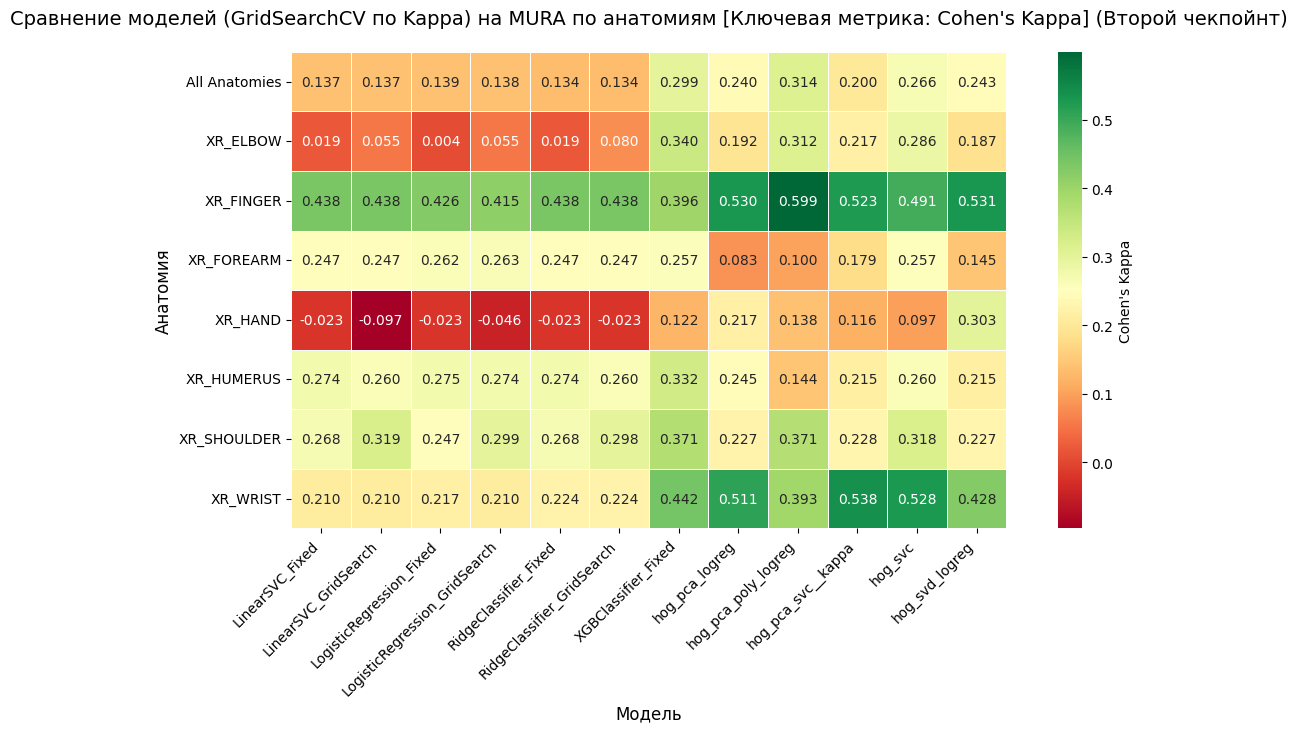

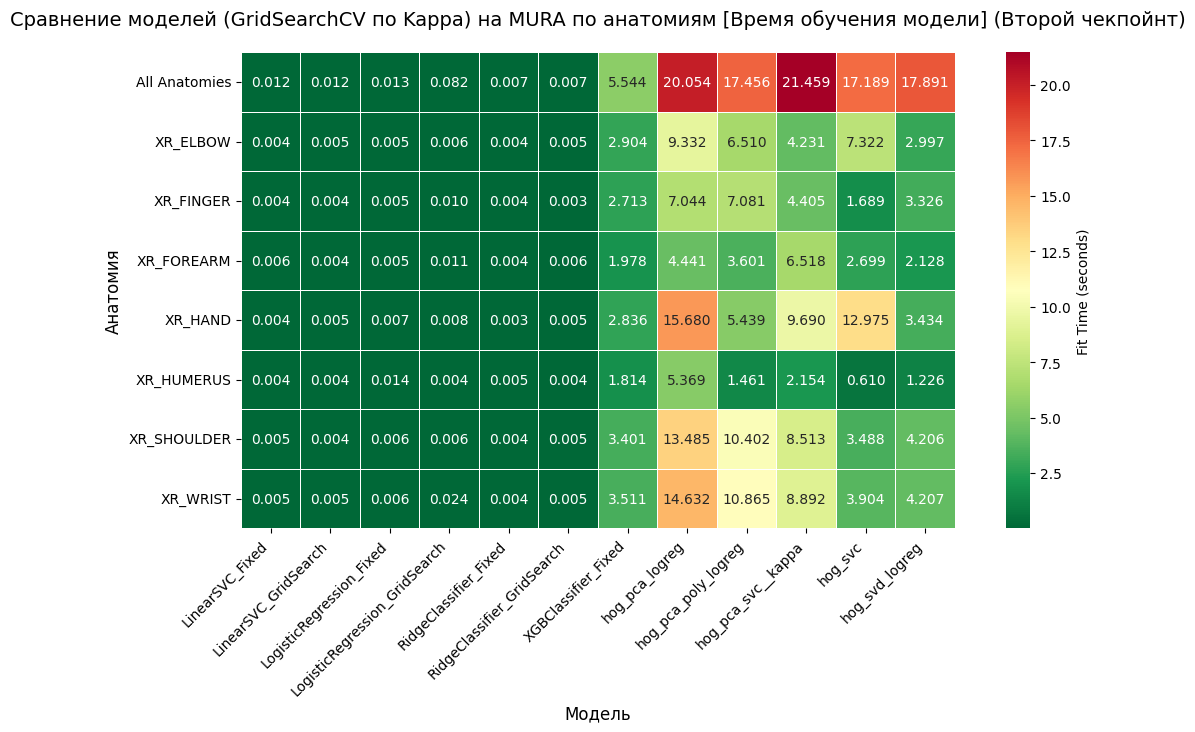

In [37]:
show_heatmap_by_results(
    total_resutls_anatomies,
    description="[Ключевая метрика: Cohen's Kappa]",
    heatmap_params={'cbar_kws': {'label': 'Cohen\'s Kappa'}},
    figsize=(12, 7)
    )
show_heatmap_by_results(
    total_resutls_anatomies,
    values_for_pivot='fit_time_seconds',
    description="[Время обучения модели]",
    heatmap_params={'cbar_kws': {'label': 'Fit Time (seconds)'}, 'fmt':".3f", 'cmap':"RdYlGn_r"},
    figsize=(12, 7)
)


# Выводы - третий чекпойнт

### Промежуточный отчёт к третьему чекпоинту

В третьего чекпоинта нашей командой была проделана работа по подготовке данных и подбору моделей:

---
За второй чекпойнт нам удалось попробовать много разного:  
- на основе усреднённых (по исследованиям) статистик по пикселям были обучены Ridge Classifier, LogisticRegression и SVM ("наивно" и с подбором параметров)
- По направленным градиентам (по каждому изображению отдельно) - был обучен XGBClassifier
- Также по направленным градиентам (усредненным по исследованию) были обучены SVM и логистичесая регрессия с применением TruncatedSVD и PCA (для отбора признаков и ускорения обучения), а также полиномального feature-engineering 2 степени.

"наивное" применение линейных моделей ожидемо не дало значимых результатов - что показывают графики выше. Однако, применение HOG (гистограммы ориентированных градиентов, в отсутствие свёрточных сетей) уже дало сильный буст целевой метрики.
Несмотря на долгое время обучение предлагается выбрать HOG + pca + feature engineering + логистическая регрессия как **бейзлайн**. 


#### **1. Предобработка изображений**

- **Улучшение качества изображений**  
  Было значительно улучшено качество изображений. Мы усилили контраст и яркость с применением адаптивного CLAHE, учитывая изначальные данных каждого отдельного изображения. Улучшены:  
  - контраст  
  - яркость  
  - динамический диапазон  
  - резкость

- **Приведение к единому размеру**  
  Все снимки приведены к одному, наиболее подходящему, размеру 224х224.

---

#### **2. Выбор метрики**
  Для оценки качества моделей была выбрана метрика Cohen’s Kappa, которая учитывает случайные совпадения, что важно при дисбалансе классов, характерном для медицинских данных.

---

### Тестирование моделей и подходов

#### **1. Линейные модели без подбора параметров**
| Модель               | Kappa |
|----------------------|-------|
| RidgeClassifier       | ≈ 0.012 |
| LinearSVC             | ≈ 0.013 |
| LogisticRegression    | ≈ 0.007 |

---

#### **2. Линейные модели с подбором гиперпараметров (GridSearchCV)**
| Модель               | Kappa |
|----------------------|-------|
| LogisticRegression    | ≈ 0.082 |
| LinearSVC             | ≈ 0.013 |
| LogisticRegression    | ≈ 0.007 |

#### **3. XGBoost + дополнительные признаки (CLAHE, HOG, LBP, PCA)**
≈0.3

Тут наблюдается значительное улучшение, по сравнению с предыдущими результатами, что вполне соответствует нашим ожиданием от мощного "библиотечного" алгоритма

---

#### **4. HOG + PCA + Polynomial Features + LogisticRegression (на всём датасете)**

| Метрика       | Значение |
|---------------|----------|
| **Valid Kappa** | **0.314** |

> На текущий момент — сильнейшая модель по совокупности метрик и стабильности результатов по выборкам.

